In [1]:
# Import libraries
import random
import numpy as np
import matplotlib.pyplot as plt

import sklearn
import sklearn.model_selection
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier

import tensorflow as tf 
import keras
import keras.regularizers
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Flatten, Dropout
from keras.layers import BatchNormalization, GaussianNoise, GaussianDropout, LeakyReLU
from keras.wrappers.scikit_learn import KerasClassifier

Using TensorFlow backend.


## Loading Dataset

In [3]:
# Load final validation data set
FV_data = np.loadtxt('../data/test_data.txt',delimiter=' ',skiprows=1)
# Load input training data set
train_data = np.loadtxt('../data/training_data.txt',delimiter=' ',skiprows=1)

# Split y_train and x_train from training set
X_Tall = train_data[:,1:]
y_Tall = train_data[:,0]

In [34]:
kf = StratifiedKFold(n_splits=5)
inds = list(kf.split(X_Tall, y_Tall))

train_idx, val_idx = inds[3]

X_train, y_train = X_Tall[train_idx], y_Tall[train_idx] 
X_val, y_val = X_Tall[val_idx], y_Tall[val_idx]

In [35]:
# Function to generate DNN of given depth and width
def create_model(layers,Pdrop):
    model = Sequential()
    model.add(Dense(layers[0],input_shape=(1000,)))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.3))
    for i in layers[1:]:
        model.add(Dense(i))
        model.add(BatchNormalization())
        model.add(LeakyReLU(alpha=0.3))
        model.add(Dropout(Pdrop))
    
    # predicting probabilities of each of the 2 classes
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    
    model.compile(loss='binary_crossentropy',optimizer='RMSprop', metrics=['accuracy'])
    return model

neural = KerasClassifier(build_fn=create_model, layers=[500,250,125,75,25], Pdrop=0.4)

In [36]:
neural.fit(X_train, y_train, batch_size=2**8, epochs=3, validation_data=(X_val, y_val))

Train on 16001 samples, validate on 3999 samples
Epoch 1/3
16001/16001 [==============================] - 5s 299us/step - loss: 0.4909 - acc: 0.7656 - val_loss: 0.4175 - val_acc: 0.8360
Epoch 2/3
16001/16001 [==============================] - 2s 137us/step - loss: 0.3478 - acc: 0.8536 - val_loss: 0.4394 - val_acc: 0.8442
Epoch 3/3
16001/16001 [==============================] - 2s 121us/step - loss: 0.3120 - acc: 0.8708 - val_loss: 0.4604 - val_acc: 0.8437


In [37]:
svm = make_pipeline(StandardScaler(), SVC(C=4.0, gamma=0.0002))
svm.fit(X_train, y_train)
print(svm.score(X_train, y_train))
print(svm.score(X_val, y_val))

0.9153177926379601
0.8417104276069017


In [38]:
GB = GradientBoostingClassifier(loss='deviance', learning_rate=0.4, n_estimators=500, max_depth=5,
                                   min_samples_split=2)

GB.fit(X_train, y_train)
print(GB.score(X_train, y_train))
print(GB.score(X_val, y_val))

0.9951878007624524
0.8399599899974993


In [39]:
pred_nn = neural.predict(X_val)
pred_svm = svm.predict(X_val)
pred_GB = GB.predict(X_val)

In [40]:
pred_comb = np.zeros(len(y_val))
for i in range(len(y_val)):
    votes = [pred_nn[i][0], pred_svm[i], pred_GB[i]]
    ones= votes.count(1)
    if ones >= 2:
        pred_comb[i] = 1
    else:
        pred_comb[i] = 0
        
accuracy_score(pred_comb, y_val)

0.8474618654663666

In [ ]:
# New one using 3 epochs and GB
# Val for first  fold: 0.8592851787053236
# Val for second fold: 0.8507873031742065
# Val for third  fold: 0.84525
# Val for fourth fold: 0.8474618654663666
# Val for fifth fold: 0.8559639909977494
# Average: 0.8517

# Old one using 6 epochs and Ada
# Val for first  fold: 0.8557860534866284
# Val for second fold: 0.8512871782054486
# Val for third  fold: 0.843
# Val for fourth fold: 0.8472118029507377
# Val for fifth  fold: 0.8534633658414603
# Average: 0.850

In [41]:
neural.fit(X_Tall, y_Tall, batch_size=2**8, epochs=3)

Epoch 1/3
20000/20000 [==============================] - 5s 242us/step - loss: 0.4749 - acc: 0.7741
Epoch 2/3
20000/20000 [==============================] - 2s 114us/step - loss: 0.3433 - acc: 0.8573
Epoch 3/3
20000/20000 [==============================] - 2s 111us/step - loss: 0.3140 - acc: 0.8701


In [42]:
svm = make_pipeline(StandardScaler(), SVC(C=4.0, gamma=0.0002))
svm.fit(X_Tall, y_Tall)
print(svm.score(X_Tall, y_Tall))

0.9096


In [43]:
GB = GradientBoostingClassifier(loss='deviance', learning_rate=0.4, n_estimators=500, max_depth=5,
                                   min_samples_split=2)

GB.fit(X_Tall, y_Tall)
print(GB.score(X_Tall, y_Tall))

0.9906


In [44]:
pred_nn = neural.predict(FV_data)
pred_svm = svm.predict(FV_data)
pred_GB = GB.predict(FV_data)

In [46]:
pred_comb = np.zeros(len(FV_data))
counts = np.zeros(len(FV_data))

for i in range(len(FV_data)):
    votes = [pred_nn[i][0], pred_svm[i], pred_GB[i]]
    ones= votes.count(1)
    counts[i] = ones
    
    if ones >= 2:
        pred_comb[i] = 1
    else:
        pred_comb[i] = 0

In [47]:
with open("outcomb2.txt", "w") as f:
    f.write("Id,Prediction\n")
    for i in range(len(pred_comb)):
        f.write("{0},{1}\n".format(i+1, int(pred_comb[i])))

(array([4269.,    0.,    0.,  583.,    0.,    0.,  610.,    0.,    0.,
        4538.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <a list of 10 Patch objects>)

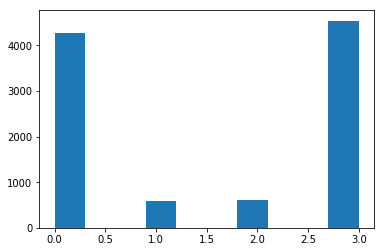

In [48]:
plt.hist(counts)